In [1]:
# IMPORTING LIBRARIES AND LOADING DATA
# All the necessary libraries for the script to run are imported below.

# Import Core Libraries 
import numpy as np  # package used for scientific computation or numerical operations.
import pandas as pd  # package used for data analysis and manipulation 
import matplotlib.pyplot as plt  # package used for creating static, animated, and interactive visualizations.
import seaborn as sns  # high-level package used for data visualization based on matplotlib, provides more attractive statistical graphics.
import warnings  # used to control warning messages, which allows to suppress them for cleaner output.
import os # provides a way of using operating system dependent functionality, like creating directories.
import re # provides regular expression operations, used here for cleaning up filenames.
from cycler import cycler # used for creating custom color cycles in plots

# Import Scikit-learn Modules for Machine Learning 
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve # tools used for splitting data, hyperparameter tuning, and model validation.
from sklearn.preprocessing import StandardScaler  # used for standardizing features by removing the mean and scaling to unit variance.
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, # used for evaluating model performance.
                             f1_score, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression  # a linear model for binary classification.
from sklearn.svm import SVC  # Support Vector Classifier, a powerful and flexible classification algorithm.
from sklearn.naive_bayes import GaussianNB  # A probabilistic classifier based on Bayes' theorem with an assumption of feature independence.
from sklearn.ensemble import RandomForestClassifier  # An ensemble method that fits multiple decision trees and averages their predictions to improve accuracy and control over-fitting.
from sklearn.calibration import calibration_curve  # used to check if a model's predicted probabilities are well-calibrated.

# Import Advanced Imputation, Neural Network, and Gradient Boosting Libraries 
from sklearn.experimental import enable_iterative_imputer # required to use the experimental IterativeImputer.
from sklearn.impute import IterativeImputer  # a sophisticated method for handling missing values by modeling each feature with missing values as a function of other features.
from tensorflow.keras.models import Model, Sequential  # provides high-level APIs for building and training deep learning models.
from tensorflow.keras.layers import Input, Dense, Dropout # provides core building blocks for neural networks: input layers, fully connected layers, and dropout layers for regularization.
from tensorflow.keras.callbacks import EarlyStopping # a keras utility to stop training when a monitored metric has stopped improving, preventing overfitting.
from xgboost import XGBClassifier # an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

# Global Settings 
# These settings apply to the entire script.
warnings.filterwarnings('ignore') # suppress all warning messages for a cleaner, more readable output.

### set a theme for a centralized color and style settings for a consistent, legible, and thematic look.
theme_colors = {
    'red': '#c91c39',
    'blue': '#0072b2',
    'grey': '#555555',
}

# Set a custom style for all plots
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', labelcolor=theme_colors['grey'], titlecolor=theme_colors['grey'], titleweight='bold')
plt.rc('text', color=theme_colors['grey'])
plt.rc('xtick', labelsize=12, color=theme_colors['grey'])
plt.rc('ytick', labelsize=12, color=theme_colors['grey'])
plt.rc('legend', fontsize=12)

# Custom color cycle for line plots (ROC, PR) to ensure distinct thematic colors
color_cycle = cycler(color=['#c91c39', '#0072b2', '#7d53de', '#00a676', '#f2a104', '#d62828'])
plt.rc('axes', prop_cycle=color_cycle)


# Create a directory to save plots 
# This block creates a folder to store all the generated graphs.
output_plot_dir = 'generated_plots' # define the name of the directory.
os.makedirs(output_plot_dir, exist_ok=True) # create the directory, `exist_ok=True` prevents an error if the directory already exists.
print(f"All generated plots will be saved in the '{output_plot_dir}/' directory.") # inform the user where the plots will be saved.

# Helper function to create valid filenames from plot titles
def sanitize_filename(title):
    """Converts a plot title into a valid filename to avoid errors when saving."""
    # Replace spaces and slashes with underscores for better file path compatibility.
    s = re.sub(r'[\s/]', '_', title)
    # Remove any character that is not a letter, number, underscore, or hyphen. This prevents invalid characters in filenames.
    s = re.sub(r'[^a-zA-Z0-9_-]', '', s)
    # Truncate the filename to 100 characters to avoid issues with path length limits and add the .png extension.
    return s[:100] + '.png'

All generated plots will be saved in the 'generated_plots/' directory.


In [2]:
# DATA PREPROCESSING WITH ITERATIVE IMPUTATION

# Load the dataset from the CSV file into a pandas DataFrame.
# `na_values='?'` tells pandas to interpret the '?' character in the data as a missing value (Not a Number or NaN).
df = pd.read_csv('heart_disease_uci.csv', na_values='?')
# Print first five records of the dataset
print(df.head())
print("---------------------------------------------------------------------------------------------")
# Print info of data
print(df.info())
print("---------------------------------------------------------------------------------------------")
# Rename the 'num' column to 'target'. This makes the purpose of the column clearer.
df.rename(columns={'num': 'target'}, inplace=True)

# Total number of male and female
print("Total number of male and female members in the data")
print(df["sex"].value_counts())
print("---------------------------------------------------------------------------------------------")
#Total number of missing values
print("Total missing values in each column")
print(df.isnull().sum())

# Binarize the target variable: The original 'num' column had values from 0 (no disease) to 4 (severe disease).
# Simplify this into a binary problem: 0 = No Disease, 1 = Any level of disease is present.
# The `apply` method with a `lambda` function is used to transform each value in the 'target' column.
if 'target' in df.columns:
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Remove identifier columns that are not useful for making predictions.
# 'id' is a unique identifier for each patient and has no predictive power.
if 'id' in df.columns:
    df = df.drop(columns=['id'])
# 'dataset' indicates the source of the data point, which is also not a predictive feature.
if 'dataset' in df.columns:
    df = df.drop(columns=['dataset'])

# ADVANCED IMPUTATION (IterativeImputer) 
# This block handles missing data using a sophisticated technique.
# IterativeImputer models each feature with missing values as a function of other features, providing more accurate imputations.

# Create a copy of the dataframe for imputation to avoid modifying the original `df` until the process is complete.
df_impute = df.copy()

# IterativeImputer can only work with numerical data. This loop converts categorical (text) columns to numerical codes temporarily.
# e.g., 'male'/'female' becomes 0/1.
for col in df_impute.select_dtypes(include=['object']).columns:
    df_impute[col] = df_impute[col].astype('category').cat.codes

# Create an instance of the IterativeImputer.
# `max_iter=10` means it will go through 10 rounds of modeling and imputing for each feature to refine its estimates.
# `random_state=42` ensures that the results are reproducible.
imputer = IterativeImputer(max_iter=10, random_state=42)
# `fit_transform` learns the relationships between features and fills in the missing values.
df_imputed_array = imputer.fit_transform(df_impute)

# The imputer returns a NumPy array, it is converted back to a pandas DataFrame, preserving the original column names.
df_imputed = pd.DataFrame(df_imputed_array, columns=df_impute.columns)

# Restore the original categorical features from the imputed numerical codes.
# This loop reverses the process from before, turning the numerical codes back into their original text categories.
for col in df.select_dtypes(include=['object']).columns:
    # Get the original text categories (e.g., 'normal', 'fixed defect').
    original_categories = df[col].astype('category').cat.categories
    # The imputed values are floats, so we round them to get the nearest integer category code.
    imputed_codes = df_imputed[col].round().astype(int)
    # `np.clip` ensures the imputed codes are within the valid range of category indices to prevent errors.
    imputed_codes = np.clip(imputed_codes, 0, len(original_categories) - 1)
    # Map the numeric codes back to the original text categories (e.g., 0 -> 'normal').
    df_imputed[col] = pd.Categorical.from_codes(imputed_codes, categories=original_categories)

# One-Hot Encode the now fully-imputed categorical columns.
# This converts categorical variables into a form that can be provided to ML algorithms to do a better job in prediction.
# e.g., a 'thal' column with values 'normal', 'fixed', 'reversable' becomes three binary columns.
categorical_cols_to_encode = df_imputed.select_dtypes(include=['object', 'category']).columns
# `pd.get_dummies` performs this transformation. `drop_first=True` removes the first category of each feature to avoid multicollinearity.
df_encoded = pd.get_dummies(df_imputed, columns=categorical_cols_to_encode, drop_first=True)

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  
--------

Exploratory Data Analysis


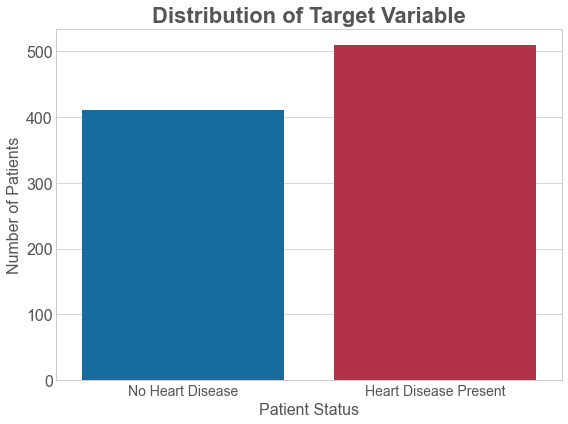

In [3]:
# EXPLORATORY DATA ANALYSIS (EDA)

print("Exploratory Data Analysis")
# Plot 1: Target Variable Distribution
plt.figure(figsize=(8, 6))
### Changed palette to thematic red and blue,increased font sizes for legibility.
sns.countplot(x='target', data=df_encoded, palette=[theme_colors['blue'], theme_colors['red']])
plt.title('Distribution of Target Variable', fontsize=22)
plt.xlabel('Patient Status', fontsize=16)
plt.ylabel('Number of Patients', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['No Heart Disease', 'Heart Disease Present'],fontsize=14)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('01_Target_Distribution')))
plt.show()


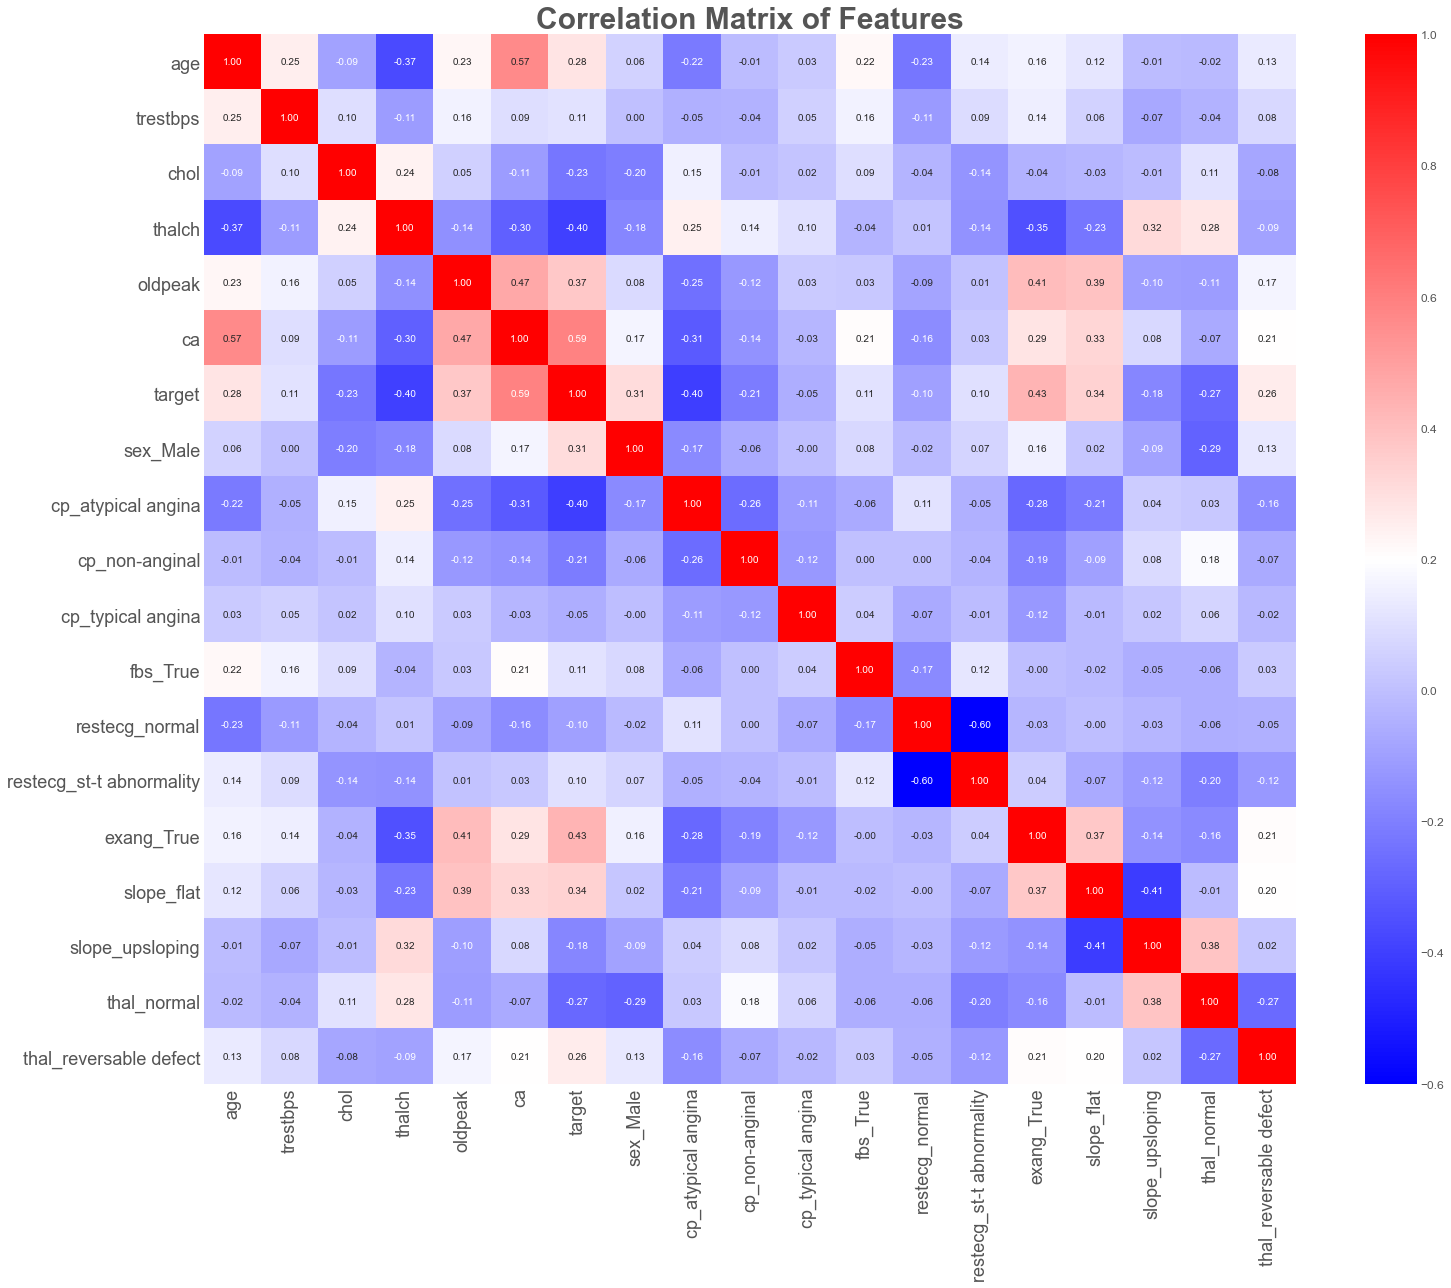

In [4]:
# Plot 2: Correlation Matrix Heatmap
plt.figure(figsize=(22, 18))
correlation_matrix = df_encoded.corr()
### Changed colormap to Blue-White-Red and increased annotation font size.
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Features', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('02_Correlation_Matrix')))
plt.show()

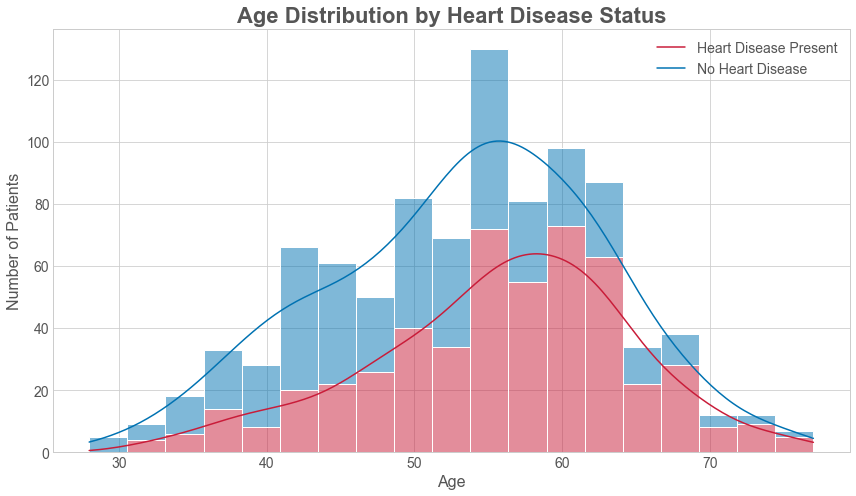

In [5]:
# Plot 3: Age Distribution by Target
plt.figure(figsize=(12, 7))
### Changed palette to thematic red and blue,increased font sizes.
sns.histplot(data=df_encoded, x='age', hue='target', kde=True, multiple='stack', palette=[theme_colors['blue'], theme_colors['red']], edgecolor='w')
plt.title('Age Distribution by Heart Disease Status', fontsize=22)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Number of Patients', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Heart Disease Present', 'No Heart Disease'], fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('03_Age_Distribution_by_Target')))
plt.show()

In [6]:
# MODEL PREPARATION

# Separate the data into features (X) and the target variable (y).
X = df_encoded.drop('target', axis=1)  # X contains all columns except the 'target' column. These are the predictors.
y = df_encoded['target']  # y contains only the 'target' column. which is to be predicted.

# Ensure all feature columns are of a numeric type (float), which is required for scaling and most ML models.
X = X.astype(float)

# Split the data into a training set (80%) and a testing set (20%).
# The model will be trained on the training set and evaluated on the unseen testing set.
# `test_size=0.2` specifies that 20% of the data will be for testing.
# `random_state=42` ensures that the split is the same every time the code is run, which is crucial for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler. This standardizes the data to have a mean of 0 and a standard deviation of 1.
# Scaling is important for many models (like SVM, KNN, and Neural Networks) that are sensitive to the scale of input features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # `fit_transform` learns the scaling parameters from the training data and then applies the transformation.
X_test_scaled = scaler.transform(X_test)    # `transform` applies the same scaling parameters learned from the training data to the test data.

# Get the number of input features for our neural networks after all preprocessing. This is the number of columns in X.
input_dim = X_train_scaled.shape[1]

--- Evaluating Logistic Regression ---


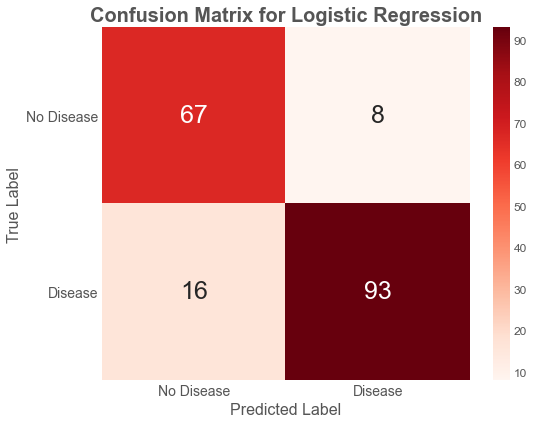

--- Evaluating Support Vector Machine ---


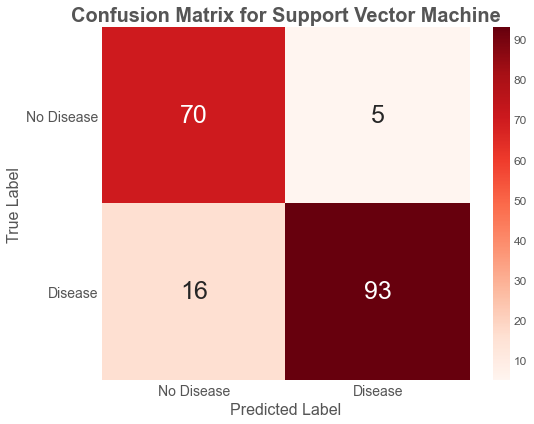

--- Evaluating Naive Bayes ---


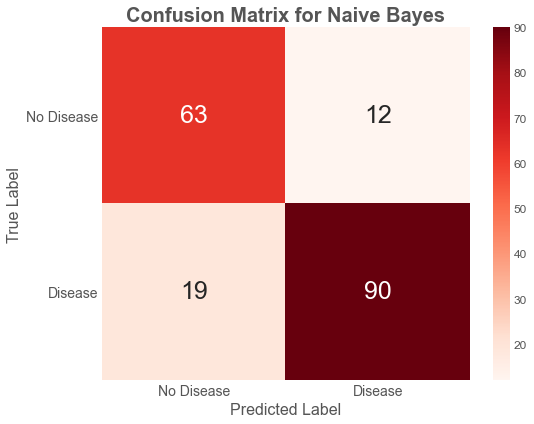

--- Evaluating Random Forest ---


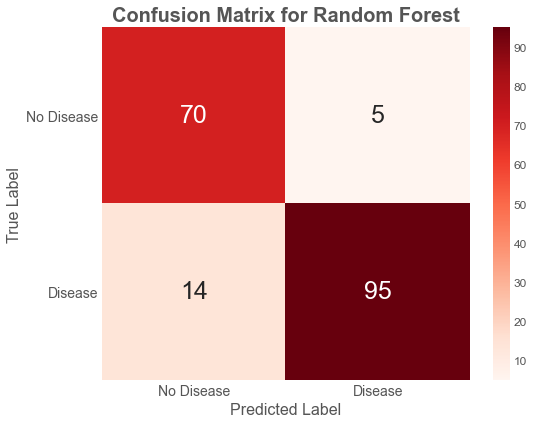

--- Evaluating XGBoost ---


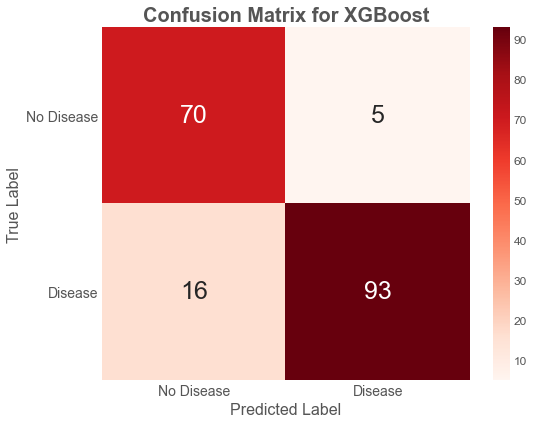


 ---Evaluating Autoencoder + DenseNet Model--- 


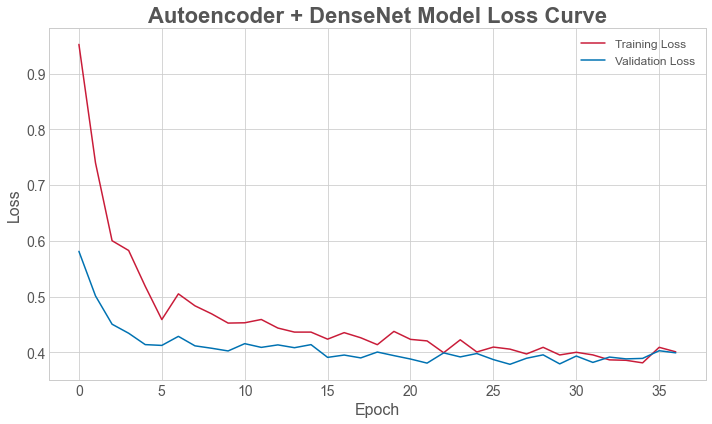

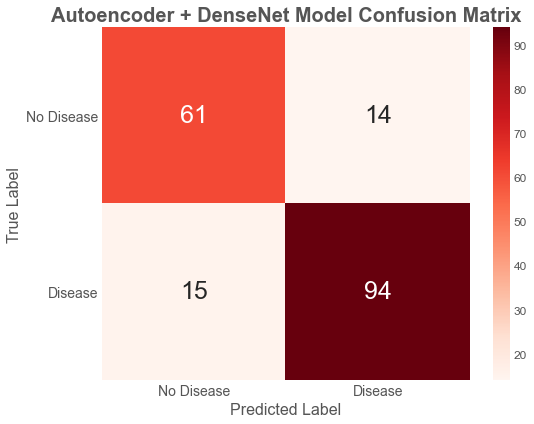

In [7]:
# MODEL TRAINING AND INDIVIDUAL EVALUATION

# Define Models and Hyperparameter Grids for Tuning 
# A dictionary to hold the classifier objects we want to train.
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True, random_state=42), # `probability=True` is needed for ROC curves.
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # XGBoost with common settings to avoid warnings.
}
# A dictionary to hold the hyperparameter search space for each model.
# GridSearchCV will test all combinations of these parameters for each model.
param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10], 'solver': ['liblinear']},
    "Support Vector Machine": {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
    "Naive Bayes": {}, # Naive Bayes has no hyperparameters to tune in this context.
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    "XGBoost": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.05]}
}

# Dictionaries to Store Results 
# These dictionaries will hold the performance metrics for each model for later comparison.
accuracies, best_estimators, auc_scores, pr_auc_scores, f1_scores = {}, {}, {}, {}, {}
sensitivities, specificities = {}, {}
roc_plot_data = {}

# Loop Through and Evaluate Each Scikit-learn Model 
# This loop automates the training and evaluation process for every model defined above.
for name, model in models.items():
    print(f"--- Evaluating {name} ---") # Print which model is being evaluated for progress tracking.
    # Use GridSearchCV to find the best hyperparameters for the model from the `param_grids`.
    # `cv=5` means 5-fold cross-validation will be used for robust evaluation.
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='accuracy')
    # Fit the GridSearchCV object on the scaled training data. This performs the search and trains the best model on the full training data.
    grid_search.fit(X_train_scaled, y_train)
    # Store the best version of the model found by the grid search.
    best_estimators[name] = grid_search.best_estimator_
    # Make predictions on the unseen test data using the best found model.
    y_pred = grid_search.predict(X_test_scaled)
    # Calculate and store metrics
    accuracies[name] = accuracy_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivities[name] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificities[name] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # PLOT 1: Confusion Matrix 
    plt.figure(figsize=(8, 6))
    ### Changed colormap to 'Reds' for a more thematic feel.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 25}, 
                xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    title = f'Confusion Matrix for {name}'
    plt.title(title, fontsize=20)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14, rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(output_plot_dir, sanitize_filename(f'04_Confusion_Matrix_{name}')))
    plt.show()

    # ROC Curve Data Collection 
    y_pred_proba = best_estimators[name].predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc
    roc_plot_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# Helper function to create the DenseNet-like Model 
# This function defines the architecture of our simple neural network.
def create_dense_net(dense_input_dim):
    # `Sequential` model means the layers are stacked in order.
    model = Sequential([
        # The first layer is a Dense (fully connected) layer with 32 neurons, using the ReLU activation function. `input_shape` is required for the first layer.
        Dense(32, activation='relu', input_shape=(dense_input_dim,)),
        # Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 during training.
        Dropout(0.2),
        # A second hidden layer with 16 neurons.
        Dense(16, activation='relu'),
        # The final output layer has 1 neuron and a sigmoid activation function, which squashes the output to a probability between 0 and 1.
        Dense(1, activation='sigmoid')
    ])
    # `compile` configures the model for training.
    # `optimizer='adam'` is a popular and effective optimization algorithm.
    # `loss='binary_crossentropy'` is the standard loss function for binary classification problems.
    # `metrics=['accuracy']` tells the model to track accuracy during training.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Helper function to create the Autoencoder Model 
# This function defines an autoencoder, which is used for unsupervised feature learning.
def create_autoencoder():
    # Define the input layer with the shape of original data.
    input_layer = Input(shape=(input_dim,))
    # The encoder part compresses the input data into a smaller representation (the bottleneck).
    encoder = Dense(16, activation='relu')(input_layer) # First encoding layer.
    encoder = Dense(8, activation='relu')(encoder)   # The bottleneck layer with 8 neurons.
    # The decoder part tries to reconstruct the original input from the compressed representation.
    decoder = Dense(16, activation='relu')(encoder) # First decoding layer.
    decoder = Dense(input_dim, activation='sigmoid')(decoder) # Output layer must match the input shape for reconstruction.
    # The autoencoder model maps the input to its reconstruction.
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse') # mse (mean squared error) is used to measure reconstruction error.
    # A separate model for just the encoder part is created, it is used for feature extraction.
    encoder_model = Model(inputs=input_layer, outputs=encoder)
    return autoencoder, encoder_model

# Evaluating the Autoencoder + DenseNet Model 
print("\n ---Evaluating Autoencoder + DenseNet Model--- ")
# Create the autoencoder and the standalone encoder models.
autoencoder, encoder_model = create_autoencoder()
# Train the autoencoder on the scaled training data to learn how to reconstruct it. `verbose=0` means it won't print progress.
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)
# Use the trained encoder to transform the original features into a new, compressed feature set.
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)
# The input dimension for our DenseNet is now the shape of this new encoded data.
autoencoder_input_dim = X_train_encoded.shape[1]
# Create the DenseNet classifier, passing the new input dimension.
auto_dense_model = create_dense_net(autoencoder_input_dim)
# Define an early stopping callback to prevent overfitting by stopping training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the DenseNet on the NEW, ENCODED data.
history = auto_dense_model.fit(X_train_encoded, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
# Store the trained model in our results dictionary.
best_estimators["Autoencoder + DenseNet"] = auto_dense_model
# Make predictions and calculate accuracy on the encoded test data.
y_pred_auto_dense = (auto_dense_model.predict(X_test_encoded) > 0.5).astype("int32")
accuracies["Autoencoder + DenseNet"] = accuracy_score(y_test, y_pred_auto_dense)
f1_scores["Autoencoder + DenseNet"] = f1_score(y_test, y_pred_auto_dense)


# Plot Loss Curve for the deep learning model.
plt.figure(figsize=(10, 6))
### Using theme colors for loss curves.
plt.plot(history.history['loss'], label='Training Loss', color=theme_colors['red'])
plt.plot(history.history['val_loss'], label='Validation Loss', color=theme_colors['blue'])
title = 'Autoencoder + DenseNet Model Loss Curve'
plt.title(title, fontsize=22)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('06_Loss_Curve_Autoencoder_DenseNet')))
plt.show()

# Plot Confusion Matrix and collect ROC data for the deep learning model.
cm_auto_dense = confusion_matrix(y_test, y_pred_auto_dense)
tn, fp, fn, tp = cm_auto_dense.ravel()
sensitivities["Autoencoder + DenseNet"] = tp / (tp + fn) if (tp + fn) > 0 else 0
specificities["Autoencoder + DenseNet"] = tn / (tn + fp) if (tn + fp) > 0 else 0

plt.figure(figsize=(8, 6))
### Changed colormap to Reds.
sns.heatmap(cm_auto_dense, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 25},
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
title = 'Autoencoder + DenseNet Model Confusion Matrix'
plt.title(title, fontsize=20)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename(f'04_Confusion_Matrix_Autoencoder_DenseNet')))
plt.show()

y_pred_proba_auto_dense = auto_dense_model.predict(X_test_encoded).ravel()
fpr_auto_dense, tpr_auto_dense, _ = roc_curve(y_test, y_pred_proba_auto_dense)
auc_scores["Autoencoder + DenseNet"] = auc(fpr_auto_dense, tpr_auto_dense)
roc_plot_data["Autoencoder + DenseNet"] = {'fpr': fpr_auto_dense, 'tpr': tpr_auto_dense, 'auc': auc_scores["Autoencoder + DenseNet"]}

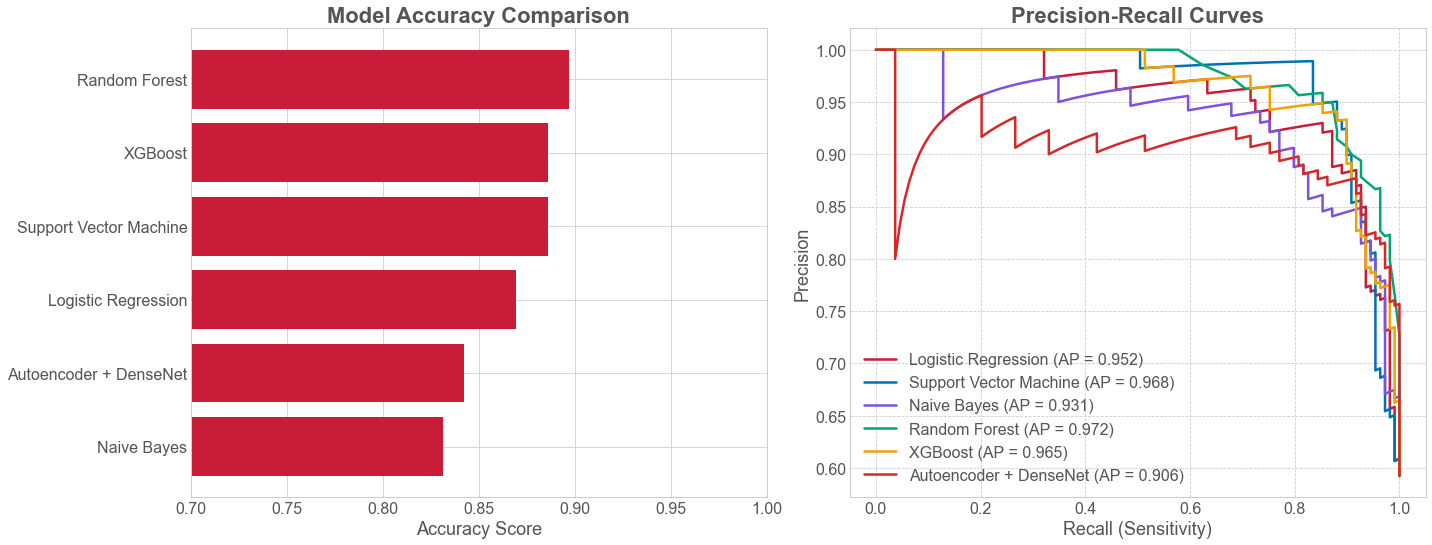

In [8]:
# OVERALL MODEL COMPARISON

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

#  Accuracy Comparison Plot (on the left subplot, ax1) 
sorted_accuracies = sorted(accuracies.items(), key=lambda item: item[1])
### Changed color to thematic red and increased font sizes
ax1.barh([item[0] for item in sorted_accuracies], [item[1] for item in sorted_accuracies], color=theme_colors['red'])
ax1.set_title('Model Accuracy Comparison', fontsize=22)
ax1.set_xlabel('Accuracy Score', fontsize=18)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_xlim(0.7, 1.0)

# Precision-Recall Curve Comparison Plot (on the right subplot, ax2) 
# The custom color cycler defined at the start will be used automatically.
for name, model in best_estimators.items():
    if "DenseNet" in name:
        y_pred_proba = model.predict(X_test_encoded).ravel()
    else:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_scores[name] = average_precision_score(y_test, y_pred_proba)
    ax2.plot(recall, precision, lw=2.5, label=f'{name} (AP = {pr_auc_scores[name]:.3f})')
ax2.set_title('Precision-Recall Curves', fontsize=22)
ax2.set_xlabel('Recall (Sensitivity)', fontsize=18)
ax2.set_ylabel('Precision', fontsize=18)
ax2.legend(fontsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.grid(True, which='both', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('07_Accuracy_and_PR_Curve_Comparison')))
plt.show()


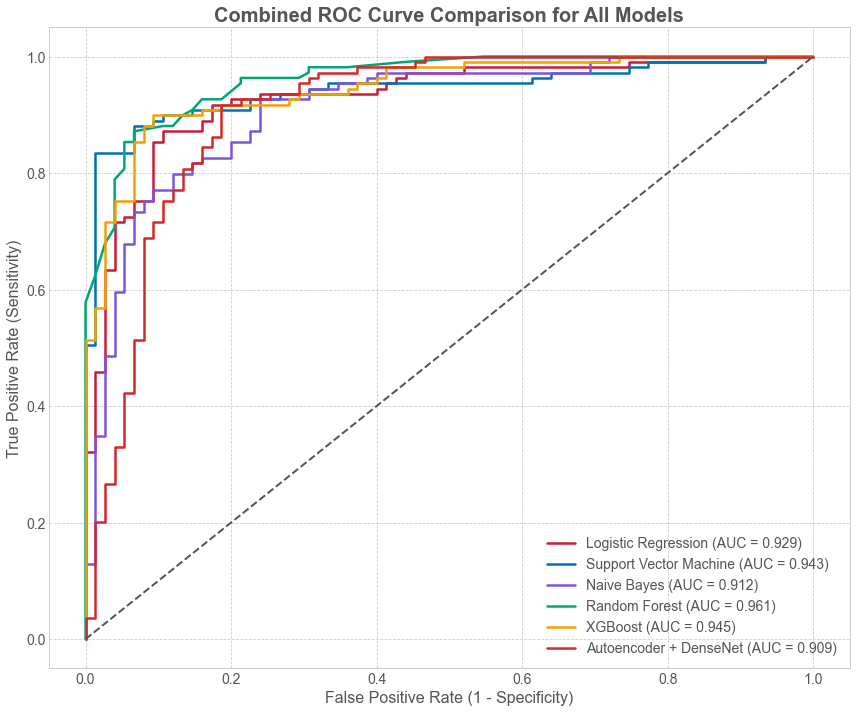

In [9]:
# COMBINED ROC CURVE COMPARISON

plt.figure(figsize=(12, 10))
# The custom color cycler will be used  automatically.
for name, data in roc_plot_data.items():
    plt.plot(data['fpr'], data['tpr'], lw=2.5, label=f'{name} (AUC = {data["auc"]:.3f})')
# Plot the random guess line
plt.plot([0, 1], [0, 1], color=theme_colors['grey'], lw=2, linestyle='--')
# Add titles and labels
plt.title('Combined ROC Curve Comparison for All Models', fontsize=20)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=16)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16)
plt.legend(loc='lower right',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('08_Combined_ROC_Curves')))
plt.show()

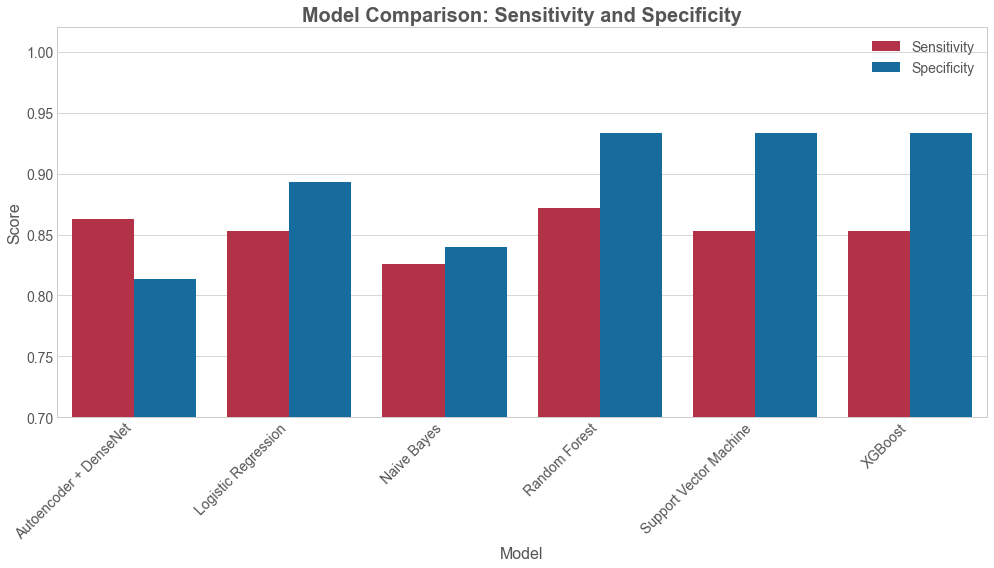

In [10]:
# SENSITIVITY AND SPECIFICITY COMPARISON

plot_data = []
model_names = sorted(sensitivities.keys())
for name in model_names:
    plot_data.append({'Model': name, 'Metric': 'Sensitivity', 'Value': sensitivities[name]})
    plot_data.append({'Model': name, 'Metric': 'Specificity', 'Value': specificities[name]})
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(14, 8))
### Using thematic blue and red for the two metrics.
sns.barplot(data=plot_df, x='Model', y='Value', hue='Metric', palette=[theme_colors['red'], theme_colors['blue']])
plt.title('Model Comparison: Sensitivity and Specificity', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.70, 1.02)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('09_Sensitivity_Specificity_Comparison')))
plt.show()

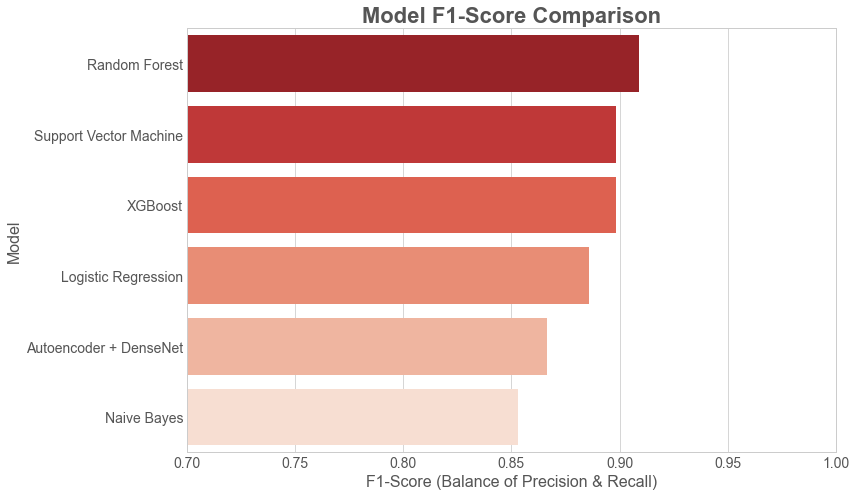

In [11]:
# F1-SCORE COMPARISON

f1_df = pd.DataFrame(f1_scores.items(), columns=['Model', 'F1-Score']).sort_values('F1-Score', ascending=False)

plt.figure(figsize=(12, 7))
### Using a sequential red palette for the bars.
sns.barplot(x='F1-Score', y='Model', data=f1_df, palette='Reds_r')
plt.title('Model F1-Score Comparison', fontsize=22)
plt.xlabel('F1-Score (Balance of Precision & Recall)', fontsize=16)
plt.ylabel('Model', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0.7, 1.0)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, sanitize_filename('10_F1_Score_Comparison')))
plt.show()

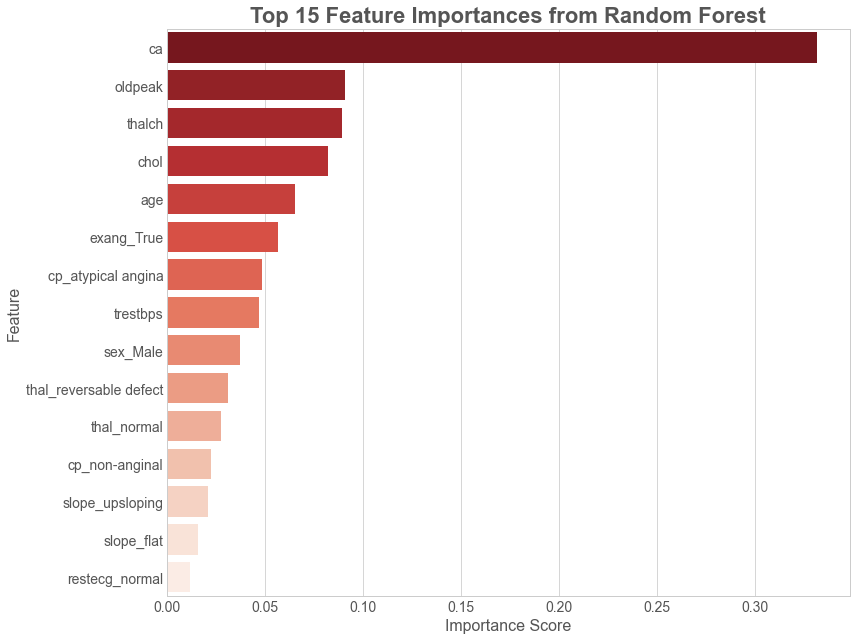

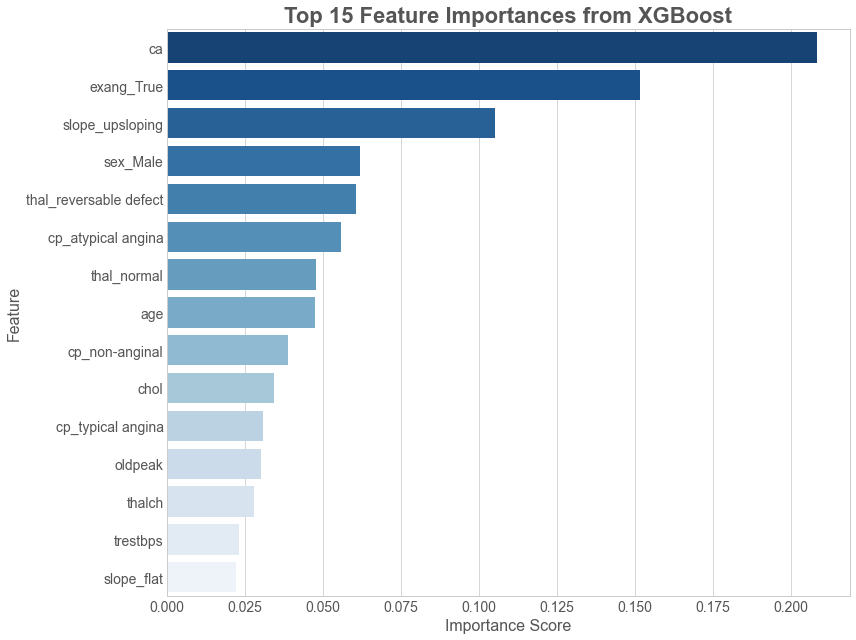

In [12]:
# FEATURE IMPORTANCE VISUALIZATION

# Random Forest Feature Importance 
rf_model = best_estimators.get("Random Forest")
if rf_model:
    importances_rf = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 9))
    ### Using sequential red palette.
    sns.barplot(x='Importance', y='Feature', data=importances_rf, palette='Reds_r')
    plt.title('Top 15 Feature Importances from Random Forest', fontsize=22)
    plt.xlabel('Importance Score', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_plot_dir, sanitize_filename('11_Feature_Importance_Random_Forest')))
    plt.show()

# XGBoost Feature Importance 
xgb_model = best_estimators.get("XGBoost")
if xgb_model:
    importances_xgb = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(12, 9))
    ### Using sequential blue palette to differentiate from RF.
    sns.barplot(x='Importance', y='Feature', data=importances_xgb, palette='Blues_r')
    plt.title('Top 15 Feature Importances from XGBoost', fontsize=22)
    plt.xlabel('Importance Score', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_plot_dir, sanitize_filename('12_Feature_Importance_XGBoost')))
    plt.show()

In [13]:
# DECIDING THE BEST MODEL

print("\n--- Final Model Evaluation and Decision ---")

# Create a summary DataFrame for a clear, tabular comparison
summary_df = pd.DataFrame({
    'Accuracy': pd.Series(accuracies),
    'ROC AUC': pd.Series(auc_scores),
    'PR AUC': pd.Series(pr_auc_scores),
    'F1-Score': pd.Series(f1_scores),
    'Sensitivity': pd.Series(sensitivities),
    'Specificity': pd.Series(specificities)
})

print("\n--- Performance Metrics Summary ---")
# Sort by F1-Score as the primary metric for this balanced task
print(summary_df.sort_values(by='F1-Score', ascending=False).to_markdown(floatfmt=".3f"))

# Find the name of the best model based on each key metric
best_accuracy_model_name = max(accuracies, key=accuracies.get)
best_auc_model_name = max(auc_scores, key=auc_scores.get)
best_pr_auc_model_name = max(pr_auc_scores, key=pr_auc_scores.get)
best_f1_model_name = max(f1_scores, key=f1_scores.get)

print("\n--- Best Model by Individual Metric ---")
print(f"Best model by Accuracy ({accuracies[best_accuracy_model_name]:.3f}): {best_accuracy_model_name}")
print(f"Best model by ROC AUC ({auc_scores[best_auc_model_name]:.3f}): {best_auc_model_name}")
print(f"Best model by PR AUC ({pr_auc_scores[best_pr_auc_model_name]:.3f}): {best_pr_auc_model_name}")
print(f"Best model by F1-Score ({f1_scores[best_f1_model_name]:.3f}): {best_f1_model_name}")


--- Final Model Evaluation and Decision ---

--- Performance Metrics Summary ---
|                        |   Accuracy |   ROC AUC |   PR AUC |   F1-Score |   Sensitivity |   Specificity |
|:-----------------------|-----------:|----------:|---------:|-----------:|--------------:|--------------:|
| Random Forest          |      0.897 |     0.961 |    0.972 |      0.909 |         0.872 |         0.933 |
| Support Vector Machine |      0.886 |     0.943 |    0.968 |      0.899 |         0.853 |         0.933 |
| XGBoost                |      0.886 |     0.945 |    0.965 |      0.899 |         0.853 |         0.933 |
| Logistic Regression    |      0.870 |     0.929 |    0.952 |      0.886 |         0.853 |         0.893 |
| Autoencoder + DenseNet |      0.842 |     0.909 |    0.906 |      0.866 |         0.862 |         0.813 |
| Naive Bayes            |      0.832 |     0.912 |    0.931 |      0.853 |         0.826 |         0.840 |

--- Best Model by Individual Metric ---
Best model by